# TFIDF

In [1]:
import pandas as pd
import numpy as np

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron

# metrics for evaluation
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch

# visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Feature Engineering

In [2]:
full_df = pd.read_csv(r'./cleaned_data/full_file.csv')
full_df.head()

full_df = full_df[['reviewText','class']].sample(2000000)
full_df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_13448\1250500672.py:1: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(r'./cleaned_data/full_file.csv')


,reviewText,class
1197303,i purchased this one for my wife. she absolute...,1
3560901,"so far, so good.its a watch with character.whe...",1
2147847,these boots run small! i wear 9 - 9.5.i ordere...,0
8303872,can not get the the cross hairs to move up. mo...,0
119591,this only keeps the charge going on the phone ...,0


In [3]:
vectorization = TfidfVectorizer(analyzer = 'word', min_df=0.0, max_features=512)
reviews = full_df['reviewText'].to_list()
X = vectorization.fit_transform(reviews).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, full_df['class'], test_size = 0.2, random_state = 0)

In [4]:
# Convert to PyTorch tensors
X_train_tfidf = torch.tensor(X_train, dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test, dtype=torch.float32)
y_train_tfidf = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test_tfidf = torch.tensor(np.array(y_test), dtype=torch.float32)


In [5]:
import pickle

# Save the model to a file using pickle
with open(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\TFIDF_vectorization_v1.pkl', 'wb') as file:
    pickle.dump(vectorization, file)
    


In [5]:
def get_stats(y_pred, model_name):
    jacard = round(jaccard_score(y_test, y_pred, average='samples') * 100, 4)
    hamming = round(hamming_loss(y_pred, y_test) * 100, 4)
    print("Results for " + model_name)
    print("Jacard score: " + str(jacard))
    print("Hamming loss: " + str(hamming))
    print()

In [6]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Modeling

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [8]:
max_len = 512  # Set maximum sequence length
batch_size = 8
num_epochs = 10
learning_rate = .0001
input_size = X_train_tfidf.shape[1]

In [20]:
max_len

512

In [9]:

# class SequentialModel(nn.Module):
#     def __init__(self, input_dim):
#         super(SequentialModel, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)  # Output dimension is 1 for binary classification

#     def forward(self, x):
#         out = torch.sigmoid(self.linear(x))  # Sigmoid activation for logistic regression
#         return out
    
class SequentialModel(nn.Module):
    def __init__(self, input_dim):
        super(SequentialModel, self).__init__()
        self.seq_model = nn.Sequential(
            nn.Linear(input_size, 128, bias=False),
            nn.Dropout(p=0.5),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),  # BatchNorm layer after the first linear layer
            nn.ReLU(),
#             nn.Dropout(p=0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):

        return self.seq_model(inputs)

# Instantiate the model
model = SequentialModel(input_dim=max_len)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Create DataLoaders
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size)


In [10]:
print(model)

SequentialModel(
  (seq_model): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [11]:
X_train_tfidf, y_train_tfidf = X_train_tfidf.to(device), y_train_tfidf.to(device)
X_test_tfidf, y_test_tfidf = X_test_tfidf.to(device), y_test_tfidf.to(device)

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [13]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for i in range(0, len(X_train_tfidf), batch_size):
        inputs = X_train_tfidf[i:i + batch_size]
        labels = y_train_tfidf[i:i + batch_size]
        labels = labels.reshape(-1,1)

        # Forward pass
        outputs = model(inputs,)
        loss_value = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        total_loss += loss_value.item()

    epoch_loss = total_loss / (len(X_train_tfidf) / batch_size)
    epoch_accuracy = (total_correct / total_samples) * 100
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    ## Testing
    with torch.no_grad():
        outputs = model(X_test_tfidf)
        predicted = torch.round(outputs)
        test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
        test_loss = criterion(predicted, y_test_tfidf.reshape(-1,1))
#         print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
        
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy* 100:.2f}%')


Epoch [1/10], Loss: 0.3902, Accuracy: 82.27% | Test Loss: 17.1682 | Test Accuracy: 82.83%
Epoch [2/10], Loss: 0.3746, Accuracy: 83.06% | Test Loss: 16.6798 | Test Accuracy: 83.32%
Epoch [3/10], Loss: 0.3686, Accuracy: 83.47% | Test Loss: 16.4130 | Test Accuracy: 83.59%
Epoch [4/10], Loss: 0.3652, Accuracy: 83.69% | Test Loss: 16.3018 | Test Accuracy: 83.70%
Epoch [5/10], Loss: 0.3632, Accuracy: 83.83% | Test Loss: 16.2107 | Test Accuracy: 83.79%
Epoch [6/10], Loss: 0.3620, Accuracy: 83.90% | Test Loss: 16.2008 | Test Accuracy: 83.80%
Epoch [7/10], Loss: 0.3608, Accuracy: 83.98% | Test Loss: 16.1252 | Test Accuracy: 83.87%
Epoch [8/10], Loss: 0.3603, Accuracy: 84.01% | Test Loss: 16.1353 | Test Accuracy: 83.86%
Epoch [9/10], Loss: 0.3597, Accuracy: 84.07% | Test Loss: 16.1080 | Test Accuracy: 83.89%
Epoch [10/10], Loss: 0.3597, Accuracy: 84.04% | Test Loss: 16.1103 | Test Accuracy: 83.89%


In [15]:
test_accuracies1 = [t*100 for t in test_accuracies]
test_losses1 = [t.cpu() for t in test_losses]

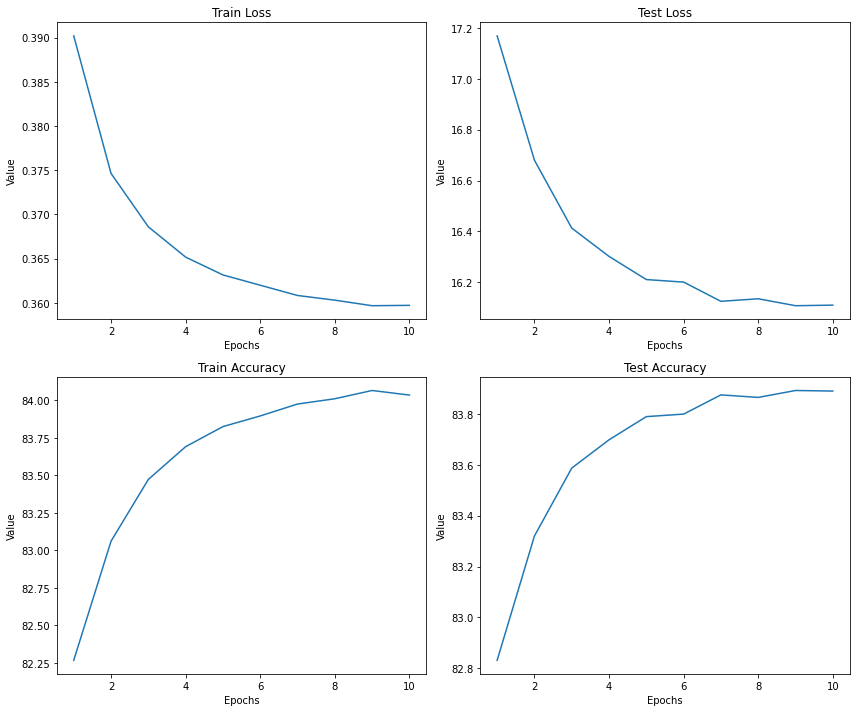

In [16]:
metrics = {
    "Train Loss": train_losses,
    "Test Loss": test_losses1,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies1
}

plt.figure(figsize=(12, 10))

for i, (title, values) in enumerate(metrics.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(range(1, len(values) + 1), values)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [17]:
# Testing the model
with torch.no_grad():
    outputs = model(X_test_tfidf)
    predicted = torch.round(outputs)
    test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
    
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_tfidf.cpu(), predicted.cpu()))

Accuracy on test set: 83.91%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84    199865
         1.0       0.84      0.83      0.84    200135

    accuracy                           0.84    400000
   macro avg       0.84      0.84      0.84    400000
weighted avg       0.84      0.84      0.84    400000



In [23]:
torch.save(model.state_dict(), r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_state.pth')

In [21]:
torch.save(model, r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_v1.pth')

In [22]:
load_model = torch.load(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_v1.pth')

# Testing the model
with torch.no_grad():
    outputs = load_model(X_test_tfidf)
    predicted = torch.round(outputs)
    test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
    
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_tfidf.cpu(), predicted.cpu()))

Accuracy on test set: 83.88%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84    199865
         1.0       0.84      0.83      0.84    200135

    accuracy                           0.84    400000
   macro avg       0.84      0.84      0.84    400000
weighted avg       0.84      0.84      0.84    400000



In [43]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 82.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    199508
           1       0.84      0.82      0.83    200492

    accuracy                           0.83    400000
   macro avg       0.83      0.83      0.83    400000
weighted avg       0.83      0.83      0.83    400000



  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

LogisticRegression
True Positive(TP)  =  163754 40.94
False Positive(FP) =  33148 8.29
True Negative(TN)  =  166360 41.59
False Negative(FN) =  36738 9.18
Accuracy of the binary classification = 0.825
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    199508
           1       0.83      0.82      0.82    200492

    accuracy                           0.83    400000
   macro avg       0.83      0.83      0.83    400000
weighted avg       0.83      0.83      0.83    400000



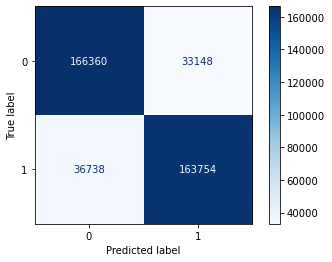

 25%|█████████████████████                                                               | 1/4 [01:31<04:35, 91.94s/it]

MultinomialNB
True Positive(TP)  =  155343 38.84
False Positive(FP) =  35894 8.97
True Negative(TN)  =  163614 40.9
False Negative(FN) =  45149 11.29
Accuracy of the binary classification = 0.797
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    199508
           1       0.81      0.77      0.79    200492

    accuracy                           0.80    400000
   macro avg       0.80      0.80      0.80    400000
weighted avg       0.80      0.80      0.80    400000



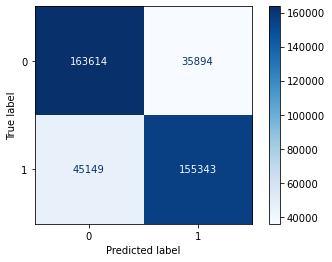

 50%|██████████████████████████████████████████                                          | 2/4 [01:34<01:18, 39.43s/it]

LinearSVC
True Positive(TP)  =  163254 40.81
False Positive(FP) =  32675 8.17
True Negative(TN)  =  166833 41.71
False Negative(FN) =  37238 9.31
Accuracy of the binary classification = 0.825
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    199508
           1       0.83      0.81      0.82    200492

    accuracy                           0.83    400000
   macro avg       0.83      0.83      0.83    400000
weighted avg       0.83      0.83      0.83    400000



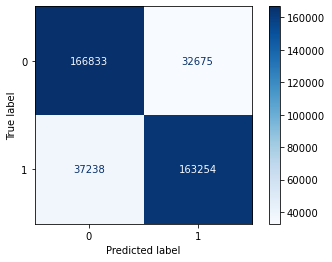

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [02:13<00:39, 39.14s/it]

Perceptron
True Positive(TP)  =  80196 20.05
False Positive(FP) =  5675 1.42
True Negative(TN)  =  193833 48.46
False Negative(FN) =  120296 30.07
Accuracy of the binary classification = 0.685
              precision    recall  f1-score   support

           0       0.62      0.97      0.75    199508
           1       0.93      0.40      0.56    200492

    accuracy                           0.69    400000
   macro avg       0.78      0.69      0.66    400000
weighted avg       0.78      0.69      0.66    400000



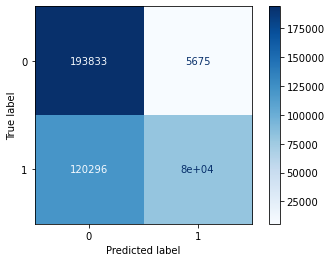

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:22<00:00, 35.53s/it]


In [46]:
from tqdm import tqdm

lr = LogisticRegression(max_iter = 400)
mn = MultinomialNB()
svc = LinearSVC()
perc = Perceptron()

model_list = [lr, mn, svc, perc]
accuracy_list = []
for model in tqdm(model_list):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    print(model.__class__.__name__)
    print('True Positive(TP)  = ', TP, np.round(TP / (TP+FP+TN+FN) * 100, 2))
    print('False Positive(FP) = ', FP, np.round(FP / (TP+FP+TN+FN) * 100, 2))
    print('True Negative(TN)  = ', TN, np.round(TN / (TP+FP+TN+FN) * 100, 2))
    print('False Negative(FN) = ', FN, np.round(FN / (TP+FP+TN+FN) * 100, 2))
    accuracy =  (TP+TN) /(TP+FP+TN+FN)
    print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))
    print(classification_report(y_test,predictions))
    accuracy_list.append(accuracy)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

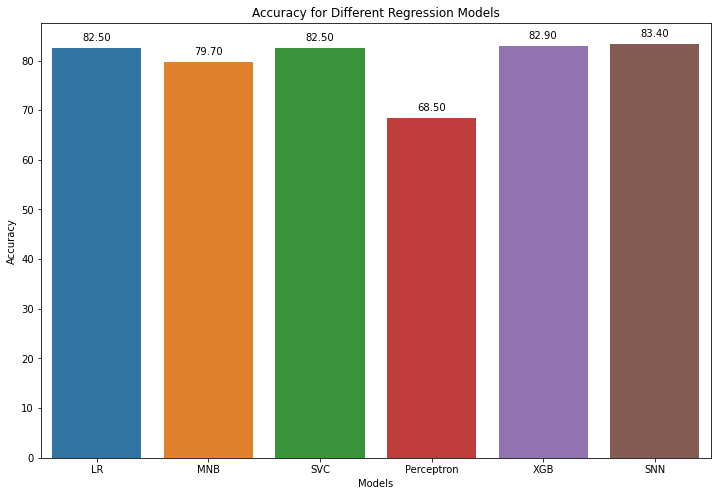

In [59]:
def compare_models(x,y,label):
    plt.rcParams["figure.figsize"] = (12,8)
    ax = sns.barplot(x=x,y=y)
    # Annotate y values on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel(label)
    plt.title(f'{label} for Different Regression Models')
    
    
## Compare R2 Values
x=['LR','MNB','SVC','Perceptron','XGB','SNN']
y=np.array(accuracy_list+[.829,.834])*100


compare_models(x,y,'Accuracy')

The The Sequencial NN model gives the best Recall, f1-score, and accuracy value. Therefore we select LR model

## Realtime Prediction

In [28]:
text = "i love this"
# text = clean_text(text)
print('-------------------------------')
print('Input Review = ',text)
print('-------------------------------')
text = vectorization.transform([text])
text = torch.tensor(text.toarray(), dtype=torch.float32).to(device)

-------------------------------
Input Review =  i love this
-------------------------------


In [31]:
a = model(text)[0]